# Rebirth the Remains
## An NLP analysis over two great brands of Brazilian Heavy Metal: Angra and Sepultura


### Motivation
In most of my time I used to experiment some NLP techniques and I noticed thjat even with the pletora of resources available, it's very hard to find some NLP Tech stuff attached with Data Analysis, _i.e._ related to generate knowledge over the data like Text Mining. 

And this is what this post what about.  

### Why Angra and Sepultura?  
Heavy Metal it's one of the most boardeless music styles in the world and I would like to show two of the most iconic bands of my country and their literary characteristics in a simple way.  

### About the Bands

#### Sepultura
According to [Wikipedia](https://en.wikipedia.org/wiki/Sepultura), Sepultura is a Brazilian heavy metal band from Belo Horizonte. Formed in 1984 by brothers Max and Igor Cavalera, the band was a major force in the groove metal, thrash metal, and death metal genres during the late 1980s and early 1990s. Sepultura has also been credited as one of the second wave of thrash metal acts from the late 1980s and early-to-mid 1990s.  

[Sepultura Oficial Website](https://www.sepultura.com.br/) - [Sepultura in Spotify](https://open.spotify.com/artist/6JW8wliOEwaDZ231ZY7cf4)

#### Angra
According to [Wikipedia](https://en.wikipedia.org/wiki/Angra_(band)), Angra is a Brazilian heavy metal band formed in 1991 that has gone through some line-up changes since its foundation. Led by Rafael Bittencourt, the band has gained a degree of popularity in Japan and Europe.   

[Angra Oficial Website](http://www.angra.net/) - [Angra in Spotify](https://open.spotify.com/artist/7IAXZaLTb6nkJr8RmVPn5y)



### Questions
Some personal questions that I always had about these bands and I'll try to answer with this notebook is: 
- 1) What's the literary characteristics for Angra and Sepultura?
- 2) Which type of thematics they talk about?
- 3) If we cluster their tematics which are the main topics discussed?

### Some limitations 

- NLP it's still an unsolved problem even with all [over promissing](https://openai.com/blog/better-language-models/) about it. This two anthologic pieces by [Yoav Goldberg](https://medium.com/@yoav.goldberg/an-adversarial-review-of-adversarial-generation-of-natural-language-409ac3378bd7) and [The Gradient](https://thegradient.pub/frontiers-of-generalization-in-natural-language-processing/) put that in perspective;
- The creative process even with some patterns it's a very complex that can envolves a lot of poetic license. [In this video](https://www.youtube.com/watch?v=G8eqnWVY_rU) Rafael Bittencourt explains the whole process to compose a single lyric for the new album, and in [this video](https://www.youtube.com/watch?v=kYf6GgkGfzA) Max Cavalera speaks about the creative process behind the classic album ["Roots"](https://www.youtube.com/watch?v=KuMlv7hmrFg&list=PLfUV806q_Ri4WN5omBcgzDxHcWMaHL_i1) from 1996.

### Applied techniques

#### Natual Language Processing
[Natural language processing (NLP)](https://en.wikipedia.org/wiki/Natural_language_processing) is a subfield of computer science, information engineering, and artificial intelligence concerned with the interactions between computers and human (natural) languages, in particular how to program computers to process and analyze large amounts of natural language data.

#### Topic Modeling
In machine learning and natural language processing, a [Topic Model](https://en.wikipedia.org/wiki/Topic_model) is a type of statistical model for discovering the abstract "topics" that occur in a collection of documents. Topic modeling is a frequently used text-mining tool for discovery of hidden semantic structures in a text body. Topic models are also referred to as probabilistic topic models, which refers to statistical algorithms for discovering the latent semantic structures of an extensive text body. 

#### Latent Dirichlet Allocation
In natural language processing, [Latent Dirichlet allocation](https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation) (LDA) is a generative statistical model that allows sets of observations to be explained by unobserved groups that explain why some parts of the data are similar. For example, if observations are words collected into documents, it posits that each document is a mixture of a small number of topics and that each word's presence is attributable to one of the document's topics. LDA is an example of a topic model.  










### Data extraction and load
To extract the lyrics I used [`PyLyrics`](https://github.com/geekpradd/PyLyrics) library using [this script](https://github.com/fclesio/metalbr/blob/master/data-extraction.py). Important: This library doesn't have any update/bug fix since last year. 







In [2]:
import os 
import re
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import spacy
import string
import nltk
from collections import Counter
from spacy.lang.en import English

# Define function to cleanup text by removing 
# personal pronouns, stopwords, and puncuation
nlp = spacy.load("en_core_web_sm")
punctuations = string.punctuation

# Datasets
fileDir = os.path.dirname(os.path.realpath('__file__'))
filename = os.path.join(fileDir, 'data/rebirth-remains.csv')

# Load file
df_raw_lyrics = pd.read_csv(filename, index_col=False)
df_raw_lyrics.columns = ['index','artist','album','lyric']

# Backup to not use the Google API to get the language again
df = df_raw_lyrics

# One limitation of the wrapper that I used to get the data
# it's that contains a lot of bad records
df_raw_lyrics = df_raw_lyrics[pd.notnull(df_raw_lyrics['lyric'])]
df_raw_lyrics = df_raw_lyrics[~df_raw_lyrics["lyric"].str.contains("<span style=")]
df_raw_lyrics = df_raw_lyrics[~df_raw_lyrics["lyric"].str.contains("padding")]
df_raw_lyrics = df_raw_lyrics[~df_raw_lyrics["lyric"].str.contains("<img")]

# Basic counters
print(f'Qty rows: {df_raw_lyrics.shape[0]}, Qty columns: {df_raw_lyrics.shape[1]}')

# First look in the data
df_raw_lyrics.head(5)

Qty rows: 325, Qty columns: 4


,index,artist,album,lyric
0,0,sepultura,Bestial Devastation,"The curse is launched, beware\nThe Lord of Dea..."
1,1,sepultura,Bestial Devastation,A legion of demons\nBorn from boundaries of de...
2,2,sepultura,Bestial Devastation,Born from Hell\nThe supreme force of evil\nTo ...
3,3,sepultura,Bestial Devastation,The misfits high in this night\nCan feel the p...
4,4,sepultura,Bestial Devastation,Marching over the mist\nLeaving behind the wea...


The wrapper fetched 325 songs bringing the artist , lyric, and album.  

One of the main challenges it's that these band susually write songs in multi-language (EN and PT-BR). For a matter of simplicity we'll concentrate only in the EN language.  

To filter the PT-BR songs I'll use `textblob` library that uses the Google API to check the language. The main caveat it's if you re-run a lot of times maybe you receive the code `HTTP Error 429: Too Many Requests`. 

In [3]:
def get_language(text):
    from textblob import TextBlob
    text = str(text)
    b = TextBlob(text)
    return b.detect_language()

# Include language in the DF
df_raw_lyrics['lang'] = df_raw_lyrics['lyric'].apply(get_language)

# Show stats about the language per artist
df_raw_lyrics.groupby(['artist', 'lang']).size().reset_index()

,artist,lang,0
0,angra,en,119
1,angra,pt,4
2,sepultura,en,194
3,sepultura,ja,1
4,sepultura,pt,7


Here we can see that from 325 lyrics 38% is from Angra and 62% is from Sepultura. Angra have 96% (119) of all dataframe lyrics in EN and Sepultura have 96% (194) of all lyrics in EN. 

The most remarkble song in PT-BR from Angra (IMHO) it's [Caça e Caçador](http://www.darklyrics.com/lyrics/angra/huntersandprey.html#8) what was a song from the album Hunters and Pray. In the Temple of Shadows album the song [Late Redemption](http://www.darklyrics.com/lyrics/angra/templeofshadows.html#12) it's a good piece in EN/PT-BR. 

Sepultura has some songs in PT-BR like [Filhos do Mundo](http://www.darklyrics.com/lyrics/sepultura/bestialdevastationsculoxx.html#7) from Bestial Devastation, [Prenuncio](http://www.darklyrics.com/lyrics/sepultura/against.html#17) from Against and [A Hora E A Vez Do Cabelo Nascer](https://www.letras.mus.br/sepultura/844256/) from the Beneath the Remains album that is a [cover song from Mutantes](https://www.youtube.com/watch?v=87vwhDPA8Z4). [The most remarkble](https://www.youtube.com/watch?v=4CWrVCAgcjg) one in PT-BR it's the [Policia](http://www.darklyrics.com/lyrics/sepultura/bloodrooted.html#3) song. 



In [13]:
# Filtering out non-EN songs
df_raw_lyrics = df_raw_lyrics[df_raw_lyrics['lang'] == 'en']

With all PT-BR lyrics removed let's perform a quick check in all albuns of these bands.

In [12]:
# Lyrics per album
df_raw_lyrics.groupby(['artist', 'album']).size().reset_index()

,artist,album,0
0,angra,Angels Cry,9
1,angra,Aqua,10
2,angra,Aurora Consurgens,11
3,angra,Fireworks,11
4,angra,Freedom Call,8
5,angra,Holy Land,10
6,angra,Holy Live,4
7,angra,Hunters and Prey,7
8,angra,Omni,10
9,angra,Reaching Horizons,9


In a first look, considering our dataframe, we can see a first difference between these two bands that Sepultura has a larger discography and more songs per album.  

This can be explained with the fact that even both bands faced an hiatus in the time of that they changed their main singers ([Andre Matos](https://pt-br.facebook.com/AndreMatosOfficial/) and [Edu Falaschi](https://en.wikipedia.org/wiki/Eduardo_Falaschi) in Angra and [Max Cavalera](https://en.wikipedia.org/wiki/Max_Cavalera) by Sepultura) Sepultura released 8 albuns after their break (all of them with [Derrick Green](https://en.wikipedia.org/wiki/Derrick_Green)) and in meanwhile Angra released 6; and Sepultura it's a more profilic band.  

Let's keep that information in mind because maybe it can be explained in a second moment in this analysis. 

Let's check the average songs per album.

In [14]:
# Average songs per album
df_albuns = df_raw_lyrics.groupby(['artist', 'album']).size().reset_index()
df_albuns.columns = ['artist', 'album', 'qty_tracks']
df_albuns.groupby(['artist']).agg({'qty_tracks': [np.size, np.mean]}).reset_index()

artist qty_tracks           
                   size       mean
0      angra         13   9.153846
1  sepultura         18  10.777778

As we visually inspected Sepultura not even have more albuns, but have more songs per album. 

To start our analysis one important aspect of Text analysis it's the Pre-Processing. Here we're literally can screw all analysis because the Pre-Processing it's responsible to remove all noise of the data and normalize all data to get meaningful results. [Kavita Ganesan](http://kavita-ganesan.com/text-preprocessing-tutorial/) made a great analysis over this topic.  


The first step will be to remove all english [stopwords](https://en.wikipedia.org/wiki/Stop_words) of all lyrics.  

PS: Personally I don't like to use of-the-shelf stopwords list because every domain demands specific words subsets to define if some word it's important or not. But let's keep that way for a matter of simplicity. This nice text of [Martina Pugliese](https://martinapugliese.github.io/english-stopwords/) explains it in detail. In terms of implementation [this article of ML Whiz](https://mlwhiz.com/blog/2019/01/17/deeplearning_nlp_preprocess/) probably its the best resource available in internet. 




In [21]:
# Convert the lyrics to String to not break the posterior convertions
df_raw_lyrics['lyric'] = df_raw_lyrics['lyric'].astype(str)

from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
stop = ENGLISH_STOP_WORDS

# Remove all stopwords
df_raw_lyrics['lyric'] = df_raw_lyrics['lyric'].apply(lambda x: ' '.join([item for item in x.lower().split() if item not in stop]))

# Quick check
df_raw_lyrics.head(5)

,index,artist,album,lyric,lang
0,0,sepultura,Bestial Devastation,"curse launched, beware lord death declared war...",en
1,1,sepultura,Bestial Devastation,legion demons born boundaries death like onsla...,en
2,2,sepultura,Bestial Devastation,born hell supreme force evil destroy altar sla...,en
3,3,sepultura,Bestial Devastation,misfits high night feel presence death way mor...,en
4,4,sepultura,Bestial Devastation,marching mist leaving weakest going endless wa...,en


After the stopwords removal, let's perform a quick visual check on the most frequent words used by these two bands. In other words: What's most used words in their composition. 

In [25]:
# Data exploration in some specific class to see the most frequent words
def get_word_frequency(artist):
    #from nltk.corpus import stopwords
    #stoplist = set(stopwords.words("english"))
    
    from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
    stoplist = ENGLISH_STOP_WORDS

    # Word Frequency per Category
    def cleanup_text(docs, logging=False):
        texts = []
        counter = 1
        for doc in docs:
            if counter % 1000 == 0 and logging:
                print("Processed %d out of %d documents." % (counter, len(docs)))
            counter += 1
            doc = nlp(doc, disable=['parser', 'ner'])
            tokens = [tok.lemma_.lower().strip() for tok in doc if tok.lemma_ != '-PRON-']
            tokens = [tok for tok in tokens if tok not in stoplist and tok not in punctuations]
            tokens = ' '.join(tokens)
            texts.append(tokens)
        return pd.Series(texts)

    df_text = [text for text in df_raw_lyrics[df_raw_lyrics['artist'] == artist]['lyric']]
    df_text_clean = cleanup_text(df_text)
    df_text_clean = ' '.join(df_text_clean).split()
    df_text_clean_counts = Counter(df_text_clean)
    df_common_words = [word[0] for word in df_text_clean_counts.most_common(31)]
    df_common_counts = [word[1] for word in df_text_clean_counts.most_common(31)]
    df_common_words.pop(0)
    df_common_counts.pop(0)

    fig = plt.figure(figsize=(18,6))
    sns.barplot(x=df_common_words, y=df_common_counts)
    plt.title(f'Most Common Words used by {artist}')
    plt.xticks(rotation=45)
    plt.show()

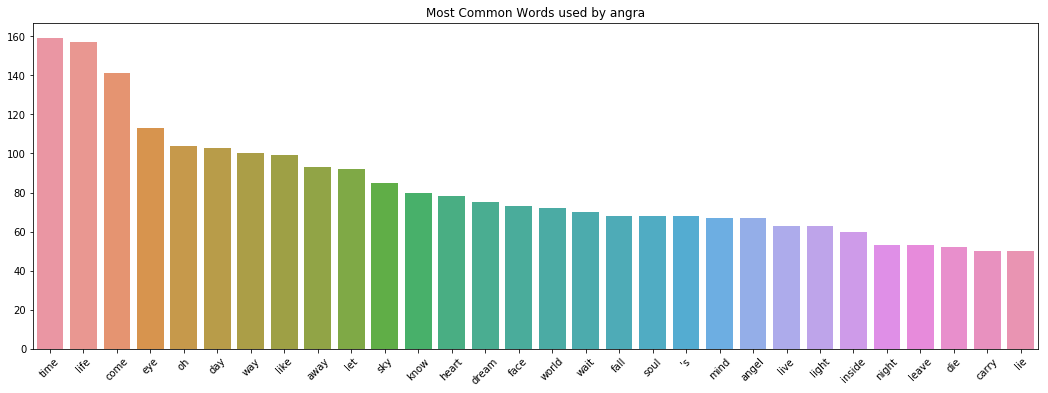

In [26]:
# Most Common words: Angra
get_word_frequency('angra')

If I could to perform some classification here to define Angra Lyrics based in their most common expressions would be like that: 

- Relation with time: `Time`, `Day`, `Wait`, `Night`  


- Feelings: `Like`, `Heart`, `Soul`, `Lie`  

    
- Moviment and distance: `Come`, `Way`, `Away`, `Carry`  


- Human issues: `Life`, `Let`, `Know`, `Dream`, `Mind`, `Live`, `inside`, `Leave`  

    
- Absolute state of the world: `Die`  

    
- Typical Heavy Metal cliche expression: `Oh`


Now, quick verification in Sepultura lyrics:

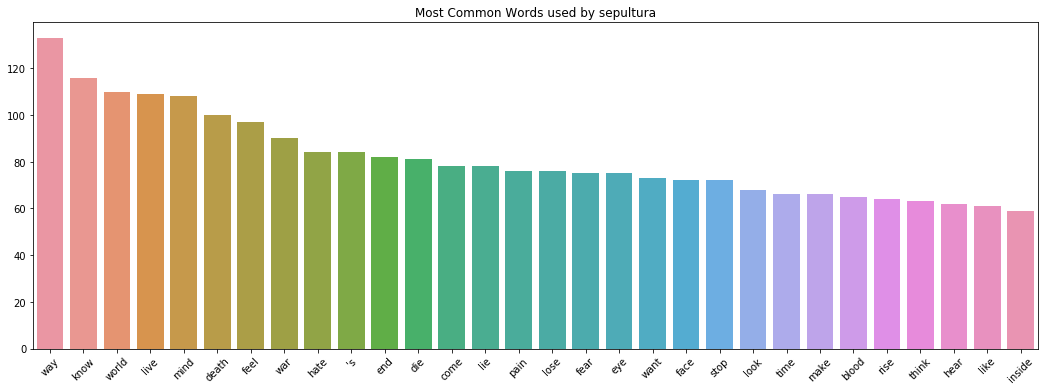

In [27]:
# Most Common words: Sepultura
get_word_frequency('sepultura')

State of the modern world: `Death`, `War`, `Hate`, `Die`, `Lie`, `Pain`, `Lose`, `Fear`, `Blood`, `World`

Action, distance and time: `Way`, `Come`, `Stop`, `Make`, `Rise`, `Time`, `Think`, `Hear`, `Know`

Mind issues: `Live`, `Mind`, `Feel`, `Want`, `Look`, `Inside`


Some latent differences about the themas discussed between Sepultura and Angra arises like:  

- O eixo de literario de composicao do Sepultura converge para assuntos ligados a tematica de coisas/sentimentos ligados a morte, a dor, guerra, odio (if you already don't know, Sepultura means "grave" in PT-BR) o que sao temas considerados mais agressivos/pesados;  

- E o Angra por sua vez tem uma tematica mais leve falando mais de questões existenciais que envolve o passar do tempo, bem como algumas musicas que tem sentimentos ligados a sonhos e sentimentos ligados a conflitos internos.  



Vamos ver a nuvem de falavras (Word Cloud) relativa as palavras mais frequentes das duas bandas, apenas para titulo de comparacao absoluta de acordo com todo o vocabulario usado pelas bandas.

In [31]:
# Word cloud with most common words
def show_wordcloud(text, artist):
    from PIL import Image
    from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
    
    from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
    STOPLIST = ENGLISH_STOP_WORDS
    

    # Create and generate a word cloud image:
    wordcloud = WordCloud(stopwords=STOPLIST, background_color="white").generate(text)

    # Display the generated image:
    fig = plt.figure(figsize=(25,10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for the {artist} category', fontsize=20)
    plt.axis("off")
    plt.show()
    
def get_wordcloud(df, artist):
    dataframe = df[df['artist'] == artist]
    # Get all texts and generate a cloud
    text = " ".join(review for review in dataframe.lyric)
    show_wordcloud(text, artist) 

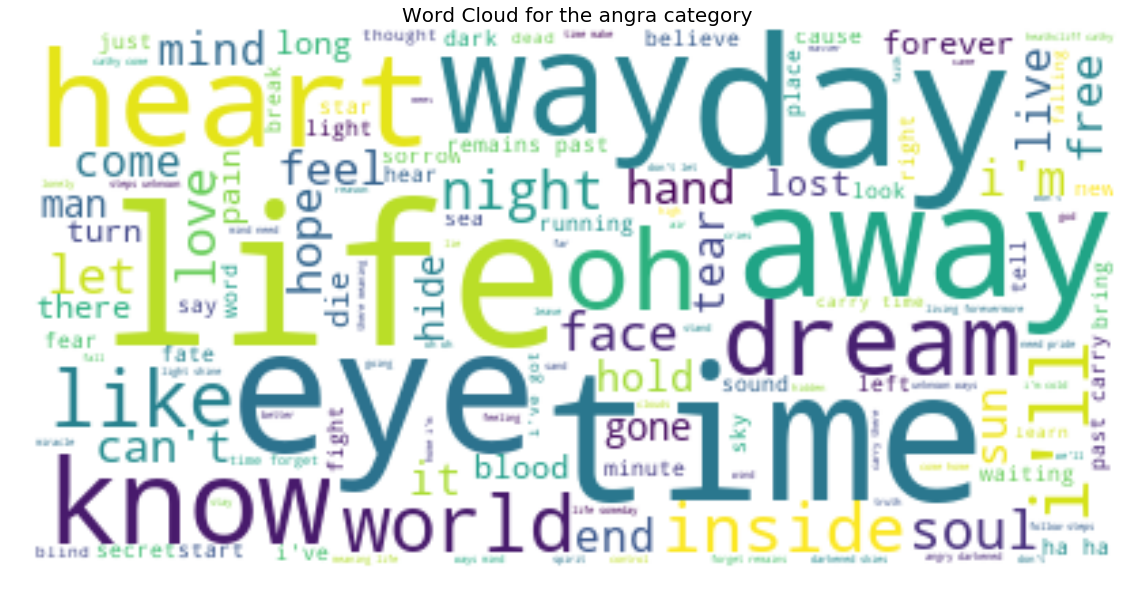

In [32]:
get_wordcloud(df_raw_lyrics, 'angra')

Main words:
 - `life`, `time`, `know`, `heart`, `day`, `away`, `know`, `dream`

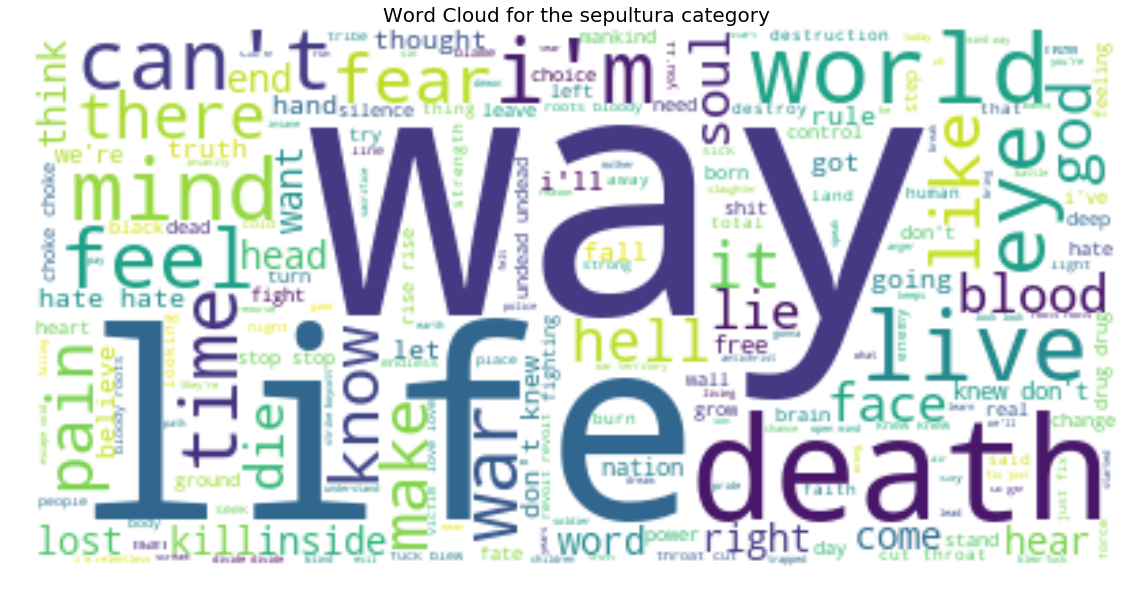

In [33]:
get_wordcloud(df_raw_lyrics, 'sepultura')

Main words:
 - `way`, `life`, `death`, `world`, `mind`
 


### Lexical Diversity

According to [Johansson](https://journals.lub.lu.se/LWPL/article/view/2273) (2009) Lexical diversity is a measure of how many different words that are used in a
text. The practical use of the Lexical Diversity it's given by [McCarthy and Jarvis](https://link.springer.com/article/10.3758%2FBRM.42.2.381) (2010) the they said that LD is the range of different words used in a text, with a greater range indicating a higher diversity.


A special consideration here it's that Heavy Metal songs (and removing Rap music that contain lots os words) doesn't contain a lot of different words or richness. It's because each band can follow a single artistic concept and _shape their creative efforts_ to some themes. 

For example [Avatasia](https://en.wikipedia.org/wiki/Avantasia) it's a supergroup of Heavy Metal that talks about fiction, fantasy and religion; and in the other side [Dream Theater](https://en.wikipedia.org/wiki/Dream_Theater) talks about almost everything since [religion](https://genius.com/Dream-theater-in-the-name-of-god-lyrics) until [modern politics](https://www.azlyrics.com/lyrics/dreamtheater/thegreatdebate.html).


With this disclaimer let's check the Lexical Diversity of this bands.

In [1]:
def get_lexical_diversity(df, artist):
    dataframe = df[df['artist'] == artist]

    full_text_count = pd.DataFrame(Counter(" ".join(dataframe["lyric"]).split()), index=[0])
    full_text_count = full_text_count.T
    full_text_count = full_text_count.reset_index()
    full_text_count.columns = ['word', 'qty']

    distinct_words = set()
    dataframe['lyric'].str.lower().str.split().apply(distinct_words.update)
    total_distinct_words = len(distinct_words)

    total_words = full_text_count['qty'].sum()

    lexical_diversity = round((total_distinct_words / total_words),2)

    print(artist, lexical_diversity)
    
    return artist, lexical_diversity

In [35]:
get_lexical_diversity(df_raw_lyrics, 'angra')

angra 0.24


('angra', 0.24)

In [36]:
get_lexical_diversity(df_raw_lyrics, 'sepultura')

sepultura 0.25


('sepultura', 0.25)

There's no lexical diversity differences between them, _i.e._ even using different words to shape their themas, there's no substantial lexical differences between them in terms of frequency in their themes.


### NGrams

According to Wikipedia [n-gram is a contiguous sequence of n items from a given sample of text or speech. The items can be phonemes, syllables, letters, words or base pairs according to the application](https://en.wikipedia.org/wiki/N-gram). 

In other others, n-grams it's sequences that contains _n_ words that can be used to model the probability of some sequence appears in a corpus, in our case, the n-gram(s) we can examine the most frequent combination of _n_ words in their literary dictionary.

For a matter of simplicity will focus in combinations of Bigrams `n=2` e Trigrams `n=3`.

In [37]:
from sklearn.feature_extraction.text import CountVectorizer

def get_word_ngrams_list(df, artist, word_ngram):

    def get_top_word_n_bigram(corpus, n=None):
        vec = CountVectorizer(ngram_range=(word_ngram, word_ngram)).fit(corpus)
        bag_of_words = vec.transform(corpus)
        sum_words = bag_of_words.sum(axis=0) 
        words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
        words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
        return words_freq[:n]


    common_words = get_top_word_n_bigram(df[df['artist'] == artist]['lyric'], 20)
    df3 = pd.DataFrame(common_words, columns = ['desc' , 'count'])

    return df3

In [38]:
get_word_ngrams_list(df_raw_lyrics, 'angra', 2)

,desc,count
0,carry on,29
1,remains past,24
2,we re,24
3,ve got,23
4,ha ha,19
5,me cathy,18
6,you re,18
7,on time,16
8,time forget,16
9,forget remains,16


Aqui ja podemos ver algumas coisas:

- O bigrama mais frequente eh `carry on` mas isso tem uma razao relativa aos dados: Nesse conjunto de dados temos os discos `Angels Cry` e `Holy Live` que contem a musica [Carry On](https://www.azlyrics.com/lyrics/angra/carryon.html) e isso ocasiona um _double counting_;  

- The reason behind of the `me cathy` and `cathy come` bigrams appears it's because of a cover song called [_Wuthering Heights_](https://www.azlyrics.com/lyrics/angra/wutheringheights.html) from [Kate Bush](https://en.wikipedia.org/wiki/Kate_Bush) that repeats this chorus a lot;  

- We have the tradicional heavy metal song chorus filler cliche `oh oh` appearing
    


In [39]:
get_word_ngrams_list(df_raw_lyrics, 'angra', 3)

,desc,count
0,carry on time,16
1,on time forget,16
2,time forget remains,16
3,forget remains past,16
4,remains past carry,16
5,angry darkened skies,16
6,heathcliff me cathy,16
7,me cathy come,16
8,cathy come home,16
9,come home cold,16


- Mais uma vez aparece carry on em `carry on time`, `on time forget`, `remains past carry`, 
- `Cathy` Trigrams aparece em: `heathcliff me cathy`, `me cathy come`,  `cathy come home`
- Some bizzare pattern like `ha ha ha`, probably because the data cleasing


### Sepultura

In [40]:
get_word_ngrams_list(df_raw_lyrics, 'sepultura', 2)

,desc,count
0,we re,48
1,no no,39
2,knew don,28
3,stop me,27
4,undead undead,24
5,me stop,21
6,choke choke,21
7,hate you,20
8,you hate,20
9,cut throat,19


Nesses bi-gramas ja conseguimos ver um pouco mais da tematica do Sepultura ligado a temas ligados a brutalidade confome eu tinha colocado anteriormente. Algumas mencoes:
- A musica "Choke" tem um refrão bem repetitivo, e isso contribui com essa composicao de bi-grams
- A mesma coisa com o classico "Roots" que tem um refrão bem marcante

Vamos para os tri-grams

In [41]:
get_word_ngrams_list(df_raw_lyrics, 'sepultura', 3)

,desc,count
0,no no no,26
1,undead undead undead,22
2,stop me stop,21
3,hate you hate,20
4,roots bloody roots,16
5,knew it knew,16
6,don that knew,16
7,cut throat cut,15
8,throat cut throat,15
9,me stop me,14


Aqui vemos basicamente o mesmo padrão com parte dos tri-grams voltados para alguns refrões bem marcantes.

Agora sabemos um pouco da tematica das duas bandas, entretanto uma pergunta que se segue eh: Dentro dessa tematica quais sao os topicos latentes por tras de cada composição, i.e., dado que ha uma diversidade dentro das tematicas se pudessemos agrupar essas musicas de acordo com a sua composição literaria como seria?

E aqui eh que vamos usar LDA. 

### LDA

Primeiramente vamos filtrar cada um dos artistas dentro de seus respectivos dataframes:

In [42]:
# LDA Analysis
df_raw_lyrics_angra = df_raw_lyrics[df_raw_lyrics['artist'] == 'angra']
df_raw_lyrics_sepultura = df_raw_lyrics[df_raw_lyrics['artist'] == 'sepultura']

Para realizar a distinção dos topicos eu escolhi arbitrariamente 10 topicos para cada artista (pode ser mais ou menos) apenas para efeitos didaticos e manutenção da simplicidade. 

Em outras palavras: Dado todas as letras de Angra e Sepultura, quais são os 10 principais topicos que eles geralmente compoem?

In [43]:
def get_topics(df, n_components, number_words):
    # Convert to list
    data = df.lyric.values.tolist()

    # Remove special characters
    data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

    # Remove new line characters
    data = [re.sub('\s+', ' ', sent) for sent in data]

    # Remove distracting single quotes
    data = [re.sub("\'", "", sent) for sent in data]

    vectorizer = CountVectorizer(analyzer='word',       
                                 min_df=10,                        # minimum reqd occurences of a word 
                                 stop_words='english',             # remove stop words
                                 lowercase=True,                   # convert all words to lowercase
                                 token_pattern='[a-zA-Z0-9]{3,}',  # num chars > 3
                                 # max_features=50000,             # max number of uniq words
                                )

    data_vectorized = vectorizer.fit_transform(data)

    # Materialize the sparse data
    data_dense = data_vectorized.todense()

    # Compute Sparsicity = Percentage of Non-Zero cells
    print("Sparsicity: ", ((data_dense > 0).sum()/data_dense.size)*100, "%")

    # Build LDA Model
    from sklearn.decomposition import LatentDirichletAllocation

    lda_model = LatentDirichletAllocation(n_components=n_components,               # Number of topics
                                          max_iter=10,               # Max learning iterations
                                          learning_method='online',   
                                          random_state=100,          # Random state
                                          batch_size=128,            # n docs in each learning iter
                                          evaluate_every = -1, # compute perplexity every n iters, default: Don't
                                          n_jobs = -1,               # Use all available CPUs
                                         )
    lda_output = lda_model.fit_transform(data_vectorized)

    # Helper function
    def print_topics(model, count_vectorizer, n_top_words):
        words = count_vectorizer.get_feature_names()
        for topic_idx, topic in enumerate(model.components_):
            print("\nTopic #%d:" % topic_idx)
            print(" ".join([words[i]
                            for i in topic.argsort()[:-n_top_words - 1:-1]]))

    # Print the topics found by the LDA model
    print("Topics found via LDA:")
    lda_model.fit(data_vectorized)

    print_topics(lda_model, vectorizer, number_words)
    
    return lda_model, data_vectorized, data, lda_output, vectorizer

In [44]:
lda_model_angra, data_vectorized_angra, data_angra, lda_output_angra, vectorizer_angra = get_topics(df_raw_lyrics_angra,
                                                                                  n_components=10,
                                                                                  number_words=10)

Sparsicity:  15.233207376910496 %
Topics found via LDA:

Topic #0:
time sun way world dont end day dream cause light

Topic #1:
away feel know like secrets close soul heart theres turn

Topic #2:
freedom better ground right cold blood hands dying words blind

Topic #3:
time life eyes day ill way inside away know heart

Topic #4:
soul ive heart eyes waiting like lives ill words fate

Topic #5:
life angels time theres past remains skies try lies mind

Topic #6:
let come away cold say land long ive face got

Topic #7:
world like deep love sky land waiting wonder close dead

Topic #8:
light end die come angels eyes hold dreams hide came

Topic #9:
like life understand face eyes mind standing let forever little


In [45]:
lda_model_sepultura, data_vectorized_sepultura, data_sepultura, lda_output_sepultura, vectorizer_sepultura = get_topics(df_raw_lyrics_sepultura,
                                                                                                  n_components=10,
                                                                                                  number_words=10)

Sparsicity:  9.748140414981078 %
Topics found via LDA:

Topic #0:
life live way believe mind born fear bloody lies day

Topic #1:
love hate nation destruction eyes mankind gods wrong come change

Topic #2:
dont know fuck like try wrong shit whats think face

Topic #3:
death blood hell pain inside ive feel living war world

Topic #4:
end world war eyes dead fight right free alive theres

Topic #5:
stop like dead world ill mind cause way death open

Topic #6:
time sight force trust got minds thats right black tell

Topic #7:
lost false life cause regret coming mind feel hell end

Topic #8:
way look away world just lost walk die theres face

Topic #9:
want make thought die need let live away got going


In [46]:
def get_topic_per_document(lda_model, data_vectorized, data, lda_output):
    # Create Document - Topic Matrix
    lda_output = lda_model.transform(data_vectorized)

    # column names
    topicnames = ["Topic" + str(i) for i in range(lda_model.n_components)]

    # index names
    docnames = ["Doc" + str(i) for i in range(len(data))]

    # Make the pandas dataframe
    df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

    # Get dominant topic for each document
    dominant_topic = np.argmax(df_document_topic.values, axis=1)
    df_document_topic['dominant_topic'] = dominant_topic

    # Styling
    def color_green(val):
        color = 'green' if val > .1 else 'black'
        return 'color: {col}'.format(col=color)

    def make_bold(val):
        weight = 700 if val > .1 else 400
        return 'font-weight: {weight}'.format(weight=weight)

    # Apply Style
    df_document_topics_styled = df_document_topic.head(15).style.applymap(color_green).applymap(make_bold)
    
    return df_document_topics_styled, df_document_topic

In [47]:
df_topic_per_document_angra_styled, df_topic_per_document_angra = get_topic_per_document(lda_model_angra,
                                                                                         data_vectorized_angra,
                                                                                         data_angra,
                                                                                         lda_output_angra)
df_topic_per_document_angra_styled

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,dominant_topic
Doc0,0,0,0,0,0,0.99,0,0,0,0,5
Doc1,0,0,0,0.99,0,0,0,0,0,0,3
Doc2,0,0,0,0,0,0.99,0,0,0,0,5
Doc3,0,0,0,0,0,0,0.98,0,0,0,6
Doc4,0,0,0,0,0,0,0,0,0,0.98,9
Doc5,0,0,0,0,0,0,0.98,0,0,0,6
Doc6,0,0,0,0.54,0,0.25,0.2,0,0,0,3
Doc7,0.99,0,0,0,0,0,0,0,0,0,0
Doc8,0.01,0.94,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,1
Doc9,0,0,0,0,0,0,0.98,0,0,0,6


In [48]:
df_topic_per_document_sepultura_styled, df_topic_per_document_sepultura = get_topic_per_document(lda_model_sepultura,
                                                                                                 data_vectorized_sepultura,
                                                                                                 data_sepultura,
                                                                                                 lda_output_sepultura)
df_topic_per_document_sepultura_styled

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,dominant_topic
Doc0,0.03,0.03,0.03,0.77,0.03,0.03,0.03,0.03,0.03,0.03,3
Doc1,0.01,0.01,0.01,0.22,0.01,0.74,0.01,0.01,0.01,0.01,5
Doc2,0,0,0,0.13,0,0.83,0,0,0,0,5
Doc3,0,0,0,0.96,0,0,0,0,0,0,3
Doc4,0.01,0.01,0.01,0.01,0.01,0.9,0.01,0.01,0.01,0.01,5
Doc5,0.01,0.24,0.01,0.71,0.01,0.01,0.01,0.01,0.01,0.01,3
Doc6,0,0,0,0.98,0,0,0,0,0,0,3
Doc7,0,0.29,0,0.68,0,0,0,0,0,0,3
Doc8,0,0,0,0.98,0,0,0,0,0,0,3
Doc9,0,0.37,0,0.31,0,0.23,0,0.08,0,0,1


In [49]:
def get_topic_distribution(df_document_topic):
    df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
    df_topic_distribution.columns = ['Topic Num', 'Num Documents']
    total_docs = df_topic_distribution['Num Documents'].sum()
    df_topic_distribution['perc_per_topic'] = np.round(((df_topic_distribution['Num Documents'] /total_docs) * 100), 2)

    return df_topic_distribution

In [50]:
get_topic_distribution(df_topic_per_document_angra)

,Topic Num,Num Documents,perc_per_topic
0,3,41,34.45
1,4,18,15.13
2,5,16,13.45
3,6,12,10.08
4,7,9,7.56
5,1,8,6.72
6,9,5,4.20
7,0,5,4.20
8,8,4,3.36
9,2,1,0.84


In [51]:
get_topic_distribution(df_topic_per_document_sepultura)

,Topic Num,Num Documents,perc_per_topic
0,8,40,20.62
1,3,36,18.56
2,0,36,18.56
3,5,24,12.37
4,4,12,6.19
5,2,11,5.67
6,1,10,5.15
7,6,9,4.64
8,9,8,4.12
9,7,8,4.12


In [52]:
def get_word_topics(vectorizer, lda_model):

    # Show top n keywords for each topic
    def show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=20):
        keywords = np.array(vectorizer.get_feature_names())
        topic_keywords = []
        for topic_weights in lda_model.components_:
            top_keyword_locs = (-topic_weights).argsort()[:n_words]
            topic_keywords.append(keywords.take(top_keyword_locs))
        return topic_keywords

    topic_keywords = show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=10)        

    # Topic - Keywords Dataframe
    df_topic_keywords = pd.DataFrame(topic_keywords)
    df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
    df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]

    return df_topic_keywords

In [53]:
get_word_topics(vectorizer_angra, lda_model_angra)

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9
Topic 0,time,sun,way,world,dont,end,day,dream,cause,light
Topic 1,away,feel,know,like,secrets,close,soul,heart,theres,turn
Topic 2,freedom,better,ground,right,cold,blood,hands,dying,words,blind
Topic 3,time,life,eyes,day,ill,way,inside,away,know,heart
Topic 4,soul,ive,heart,eyes,waiting,like,lives,ill,words,fate
Topic 5,life,angels,time,theres,past,remains,skies,try,lies,mind
Topic 6,let,come,away,cold,say,land,long,ive,face,got
Topic 7,world,like,deep,love,sky,land,waiting,wonder,close,dead
Topic 8,light,end,die,come,angels,eyes,hold,dreams,hide,came
Topic 9,like,life,understand,face,eyes,mind,standing,let,forever,little


In [54]:
get_word_topics(vectorizer_sepultura, lda_model_sepultura)

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9
Topic 0,life,live,way,believe,mind,born,fear,bloody,lies,day
Topic 1,love,hate,nation,destruction,eyes,mankind,gods,wrong,come,change
Topic 2,dont,know,fuck,like,try,wrong,shit,whats,think,face
Topic 3,death,blood,hell,pain,inside,ive,feel,living,war,world
Topic 4,end,world,war,eyes,dead,fight,right,free,alive,theres
Topic 5,stop,like,dead,world,ill,mind,cause,way,death,open
Topic 6,time,sight,force,trust,got,minds,thats,right,black,tell
Topic 7,lost,false,life,cause,regret,coming,mind,feel,hell,end
Topic 8,way,look,away,world,just,lost,walk,die,theres,face
Topic 9,want,make,thought,die,need,let,live,away,got,going


In [55]:
def get_LDA_plot(lda_model, data_vectorized, vectorizer):
    import pyLDAvis
    import pyLDAvis.sklearn
    %matplotlib inline

    pyLDAvis.enable_notebook()
    panel = pyLDAvis.sklearn.prepare(lda_model, data_vectorized, vectorizer, mds='tsne')
    return panel

In [56]:
get_LDA_plot(lda_model_angra, data_vectorized_angra, vectorizer_angra)

/Users/flavio.desouza/Documents/text-classification-spacy/text-classification-spacy/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
3     -312.992462 -177.986420       1        1  29.321293
5     -124.274887   79.258972       2        1  18.518784
6     -410.211639  118.178658       3        1  12.325991
4     -237.236343  377.520660       4        1  12.250156
7      319.684052  301.526794       5        1   7.092356
1      130.947891   44.427467       6        1   5.608018
9      -35.794453 -224.951508       7        1   5.380683
0       42.479206  348.716705       8        1   5.259500
8      243.853363 -253.975494       9        1   3.693008
2      416.857300    5.324873      10        1   0.550211, topic_info=    Category        Freq        Term       Total  loglift  logprob
75   Default   54.000000       light   54.000000  30.0000  30.0000
72   Default   80.000000         let   80.000000  29.0000  29.0000
4    Default   86.000000        away   86.000000  28.0000  28.0000
2    Default   57.000000      angels   57.000000  27.0000  27.0000
45   Default   18.000000     freedom   18.000000  26.0000  26.0000
76   Default   91.000000        like   91.000000  25.0000  25.0000
74   Default  133.000000        life  133.000000  24.0000  24.0000
133  Default  141.000000        time  141.000000  23.0000  23.0000
148  Default   66.000000       world   66.000000  22.0000  22.0000
125  Default   43.000000         sun   43.000000  21.0000  21.0000
6    Default   17.000000      better   17.000000  20.0000  20.0000
39   Default   39.000000        feel   39.000000  19.0000  19.0000
31   Default   33.000000         end   33.000000  18.0000  18.0000
15   Default   29.000000        cold   29.000000  17.0000  17.0000
16   Default   76.000000        come   76.000000  16.0000  16.0000
35   Default   24.000000     falling   24.000000  15.0000  15.0000
30   Default   23.000000       dying   23.000000  14.0000  14.0000
32   Default  105.000000        eyes  105.000000  13.0000  13.0000
118  Default   56.000000        soul   56.000000  12.0000  12.0000
104  Default   26.000000       right   26.000000  11.0000  11.0000
86   Default   43.000000        love   43.000000  10.0000  10.0000
147  Default   20.000000       words   20.000000   9.0000   9.0000
69   Default   37.000000        land   37.000000   8.0000   8.0000
8    Default   24.000000       blood   24.000000   7.0000   7.0000
24   Default   24.000000        deep   24.000000   6.0000   6.0000
137  Default   19.000000  understand   19.000000   5.0000   5.0000
25   Default   28.000000         die   28.000000   4.0000   4.0000
73   Default   38.000000        lies   38.000000   3.0000   3.0000
56   Default   61.000000       heart   61.000000   2.0000   2.0000
53   Default   22.000000       hands   22.000000   1.0000   1.0000
..       ...         ...         ...         ...      ...      ...
13   Topic10    0.160229       close   17.733809   0.4960  -5.0744
0    Topic10    0.141695      afraid   15.804266   0.4883  -5.1974
105  Topic10    0.148288         run   16.666630   0.4806  -5.1519
58   Topic10    0.120635      hidden   13.582456   0.4789  -5.3583
20   Topic10    0.146840        dawn   16.856512   0.4595  -5.1617
134  Topic10    0.127359    tomorrow   14.683742   0.4551  -5.3040
95   Topic10    0.150729        ones   17.442681   0.4514  -5.1356
54   Topic10    0.137065        hard   15.873918   0.4506  -5.2306
9    Topic10    0.129683       break   15.217950   0.4375  -5.2859
82   Topic10    0.142367      lonely   16.753202   0.4347  -5.1926
91   Topic10    0.136653     morning   16.115110   0.4326  -5.2336
14   Topic10    0.140190      clouds   16.582996   0.4295  -5.2080
81   Topic10    0.123743  loneliness   14.759504   0.4212  -5.3328
110  Topic10    0.133783     secrets   16.076468   0.4137  -5.2548
129  Topic10    0.144685      things   17.578089   0.4028  -5.1765
46   Topic10    0.156959      future   20.300129   0.3402  -5.0951
144  Topic10    0.153739        wind   20.187

In [57]:
get_LDA_plot(lda_model_sepultura, data_vectorized_sepultura, vectorizer_sepultura)

/Users/flavio.desouza/Documents/text-classification-spacy/text-classification-spacy/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
8     -324.515472  -13.353921       1        1  20.436083
3      -80.444275  -96.987549       2        1  16.437040
0      148.348526  -16.463001       3        1  15.552868
5       61.195976  373.203003       4        1  11.539892
7      -35.499599  141.655563       5        1   7.259408
2     -193.549850 -315.968628       6        1   6.579503
4      370.827698 -122.059799       7        1   6.487922
9      116.180405 -296.844849       8        1   6.425223
6     -252.355362  267.329895       9        1   5.159248
1      291.096802  197.815567      10        1   4.122813, topic_info=    Category        Freq         Term       Total  loglift  logprob
27   Default   86.000000         dont   86.000000  30.0000  30.0000
149  Default   64.000000         want   64.000000  29.0000  29.0000
139  Default   63.000000         time   63.000000  28.0000  28.0000
58   Default   68.000000         hate   68.000000  27.0000  27.0000
73   Default   63.000000         know   63.000000  26.0000  26.0000
129  Default   54.000000         stop   54.000000  25.0000  25.0000
89   Default   81.000000         lost   81.000000  24.0000  24.0000
29   Default   70.000000          end   70.000000  23.0000  23.0000
90   Default   32.000000         love   32.000000  22.0000  22.0000
22   Default   86.000000        death   86.000000  21.0000  21.0000
91   Default   46.000000         make   46.000000  20.0000  20.0000
21   Default   43.000000         dead   43.000000  19.0000  19.0000
33   Default   75.000000         eyes   75.000000  18.0000  18.0000
150  Default   70.000000          war   70.000000  17.0000  17.0000
37   Default   33.000000        false   33.000000  16.0000  16.0000
26   Default   62.000000          die   62.000000  15.0000  15.0000
83   Default   56.000000         like   56.000000  14.0000  14.0000
154  Default  115.000000        world  115.000000  13.0000  13.0000
137  Default   35.000000      thought   35.000000  12.0000  12.0000
97   Default   43.000000         need   43.000000  11.0000  11.0000
47   Default   33.000000         fuck   33.000000  10.0000  10.0000
84   Default   80.000000         live   80.000000   9.0000   9.0000
12   Default   45.000000        cause   45.000000   8.0000   8.0000
25   Default   24.000000  destruction   24.000000   7.0000   7.0000
111  Default   46.000000        right   46.000000   6.0000   6.0000
155  Default   34.000000        wrong   34.000000   5.0000   5.0000
63   Default   55.000000         hell   55.000000   4.0000   4.0000
78   Default   31.000000          let   31.000000   3.0000   3.0000
81   Default  119.000000         life  119.000000   2.0000   2.0000
45   Default   24.000000        force   24.000000   1.0000   1.0000
..       ...         ...          ...         ...      ...      ...
58   Topic10   22.779284         hate   68.010785   2.0948  -2.2113
98   Topic10    4.553485          new   20.900736   1.6647  -3.8212
108  Topic10    5.014267        power   23.415775   1.6475  -3.7248
13   Topic10    5.544771       change   27.641337   1.5822  -3.6243
155  Topic10    6.202562        wrong   34.117089   1.4838  -3.5122
54   Topic10    2.666673        greed   15.087598   1.4556  -4.3563
16   Topic10    5.693390         come   35.631904   1.3547  -3.5978
85   Topic10    1.806506        lives   13.821741   1.1538  -4.7457
57   Topic10    2.732164        hands   21.819059   1.1109  -4.3320
115  Topic10    1.977702         said   16.877942   1.0446  -4.6552
33   Topic10    7.549662         eyes   75.558411   0.8852  -3.3156
138  Topic10    1.436157     thoughts   15.351077   0.8194  -4.9752
99   Topic10    1.467107        night   18.267397   0.6668  -4.9538
10   Topic10    1.314448       buried   17.078036   0.6243  -5.0637
82   Topic10    1.097204        light   14.409576   0.6135  -5.2444
30   Topic10    1.113385      endless   14.659559   0.6109  -5.22

## TODO
- Include track names
- Compare Sepultura Eras (Max - Derrick)
- Compare Angra Eras (Mattos - Falaschi - Lioni)
- Similarity between tracks (Content-Based)
- Sepultura/Angra LSTM music lyric generator
- Topic evolution
- Dominant topic per album  
- Lyric Generation using LSTM







## References

- **Machine Learning Plus** - [LDA in Python – How to grid search best topic models?](https://www.machinelearningplus.com/nlp/topic-modeling-python-sklearn-examples/)  

- **Susan Li** - [Building a Content Based Recommender System for Hotels in Seattle](https://towardsdatascience.com/building-a-content-based-recommender-system-for-hotels-in-seattle-d724f0a32070)  

- **Susan Li** - [Automatically Generate Hotel Descriptions with LSTM](https://towardsdatascience.com/automatically-generate-hotel-descriptions-with-lstm-afa37002d4fc)  

- **Shashank Kapadia** - [End-To-End Topic Modeling in Python: Latent Dirichlet Allocation (LDA)](https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0)  

- **Meghana Bhange** - [Arctic Monkeys Lyrics Generator with Data Augmentation](https://towardsdatascience.com/arctic-monkeys-lyrics-generator-with-data-augmentation-b9b1f7989db0)  

- **Greg Rafferty** - [LDA on the Texts of Harry Potter](https://towardsdatascience.com/basic-nlp-on-the-texts-of-harry-potter-topic-modeling-with-latent-dirichlet-allocation-f3c00f77b0f5)  

- **Code Academy** - [Using Machine Learning to Analyze Taylor Swift's Lyrics](https://news.codecademy.com/taylor-swift-lyrics-machine-learning/)

- **Alexander Bell** - [Music Lyrics Analysis: Using Natural Language Processing to create a Lyrics-Based Music Recommender](https://medium.com/@alexwbell/music-lyrics-analysis-using-natural-language-processing-to-create-a-lyrics-based-music-recommender-43e35896a4de)

- **Trucks and Beer** - [Amazing project with Lyrics scrapper](https://github.com/johnwmillr/trucks-and-beer)

- **Anders Olson-Swanson** - [Natural Language Processing and Rap Lyrics](https://towardsdatascience.com/natural-language-processing-and-rap-lyrics-c678e60073fb)

- **Brandon Punturo** - [Drake — Using Natural Language Processing to understand his lyrics](https://towardsdatascience.com/drake-using-natural-language-processing-to-understand-his-lyrics-49e54ace3662)

- **Degenerate State** - [Heavy Metal and Natural Language Processing - Part 1](http://www.degeneratestate.org/posts/2016/Apr/20/heavy-metal-and-natural-language-processing-part-1/)

- **Degenerate State** - [Heavy Metal and Natural Language Processing - Part 2](http://www.degeneratestate.org/posts/2016/Sep/12/heavy-metal-and-natural-language-processing-part-2/)

- **Degenerate State** - [Heavy Metal and Natural Language Processing - Part 3](http://www.degeneratestate.org/posts/2017/Jun/13/heavy-metal-and-natural-language-processing-part-3/)

- **Packt_Pub** - [Generating Lyrics Using Deep (Multi-Layer) LSTM](https://hackernoon.com/generating-lyrics-using-deep-multi-layer-lstm-b28ee8124936)  

- **Mohammed Ma'amari** - [AI Generates Taylor Swift’s Song Lyrics](https://towardsdatascience.com/ai-generates-taylor-swifts-song-lyrics-6fd92a03ef7e)  

- **Notebook Taylor Swift’s Song Lyrics** - [Link in Colab](https://colab.research.google.com/drive/1wlZXZBvOo93pAmTtEUeTlPsgAP4D1bLA)  

- **enrique a.** - [Word-level LSTM text generator. Creating automatic song lyrics with Neural Networks](https://medium.com/coinmonks/word-level-lstm-text-generator-creating-automatic-song-lyrics-with-neural-networks-b8a1617104fb)  

- **Ivan Liljeqvist** - [Using AI to generate lyrics](https://medium.com/@ivanliljeqvist/using-ai-to-generate-lyrics-5aba7950903)  

- **Sarthak Anand** - [Music Generator](https://github.com/isarth/generating_lyrics)  

- **Franklin Wang** - [song-lyrics-generation](https://github.com/frankxwang/song-lyrics-generation)  

- **Tony Beltramelli** - [Deep-Lyrics](https://github.com/tonybeltramelli/Deep-Lyrics) 